# Individuel

In [ ]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from scipy.signal import find_peaks
from matplotlib.animation import FuncAnimation, FFMpegWriter
import json

# Connect to DuckDB 
con = duckdb.connect("football.duckdb")

# Sécurité mémoire
con.execute("PRAGMA threads=4;")
con.execute("PRAGMA memory_limit='4GB';")

print("DuckDB ready")

con.execute("""
CREATE OR REPLACE TABLE summary AS
SELECT *
FROM read_csv_auto('data/summary.csv')
""")

DuckDB ready


## Tableau de zone

In [2]:
player_pseudo = 1      
month = '2020-03'            # format YYYY-MM
def speed_zone(player, date):
    df_speed = con.execute(f"""
    SELECT
        strftime('%Y-%m', session_date) AS month,
        player_pseudo,
        MAX(speed_kmh) AS max_speed_kmh
    FROM tracking_games
    WHERE player_pseudo = '{player_pseudo}'
    AND strftime('%Y-%m', session_date) = '{month}'
    GROUP BY month, player_pseudo
    """).df()
    zones = [0,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    labels = [
        '0-40%',
        '40-50%',
        '50-60%',
        '60-70%',
        '70-80%',
        '80-90%',
        '90-100%'
    ]
    vmax = df_speed['max_speed_kmh'].values[0]

    df_zone = pd.DataFrame({
        'zone': labels,
        'min_speed_kmh': [vmax * z1 for z1 in zones[:-1]],
        'max_speed_kmh': [vmax * z2 for z2 in zones[1:]],
    })
    return df_zone
speed_zone(player_pseudo, month)


,zone,min_speed_kmh,max_speed_kmh
0,0-40%,0.00000,9.69408
1,40-50%,9.69408,12.11760
2,50-60%,12.11760,14.54112
3,60-70%,14.54112,16.96464
4,70-80%,16.96464,19.38816
5,80-90%,19.38816,21.81168
6,90-100%,21.81168,24.23520


## Profile accélération vitesse

Pour tracer le profil, il est proposé, à partir d’une vitesse de 3 m/s, de prendre toutes les 0,2 m/s les deux points dont l’accélération est maximale puis de calculer la droite de régression de l’accélération par rapport à la vitesse.
Miguens et al. [6] proposent une régression quantile dans le cadre du rugby.

In [16]:
#Afficher liste player_pseudo et sensor id  pour la session_date '2020-02-01'
con.execute("""
SELECT DISTINCT player_pseudo, sensor_id
FROM tracking_games
WHERE session_date = '2020-02-01'
order by player_pseudo
""").df()


,player_pseudo,sensor_id
0,1,14
1,6,10
2,9,23
3,10,4
4,11,17
5,14,13
6,19,12
7,24,11
8,25,20
9,34,5


C:\Users\theol\AppData\Local\Temp\ipykernel_11512\3761270507.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('speed_bin')


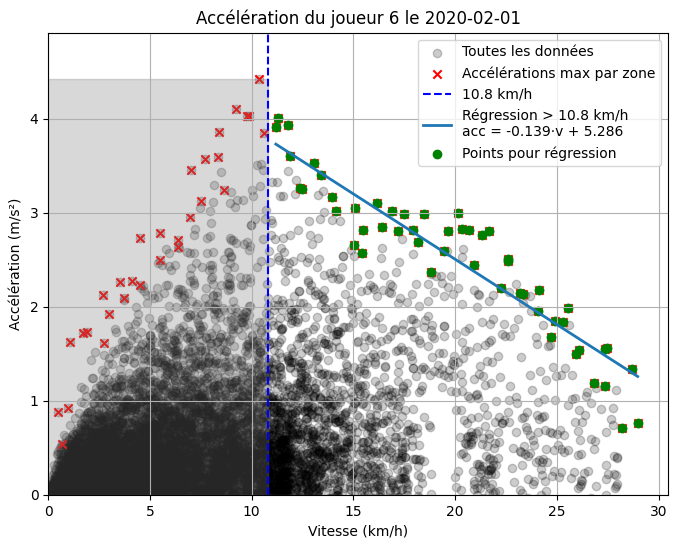

In [19]:
# ===============================
# Paramètres
# ===============================
player = 6
match = '2020-02-01'
fs = 10  # Hz
dt = 1 / fs
v_start = 0
step = 0.72
v_threshold = 10.8  # seuil pour la régression

# ===============================
# Récupération des données
# ===============================
df = con.execute(f"""
SELECT *
FROM tracking_games
WHERE session_date = '{match}'
AND player_pseudo = {player}
ORDER BY session_date
""").df()

if df.empty:
    raise ValueError(f"Aucune donnée pour le joueur {player} le {match}")

# ===============================
# Calcul de la vitesse en m/s et de l'accélération
# ===============================
df['speed_ms'] = df['speed_kmh'] / 3.6
df['acceleration'] = df['speed_ms'].diff() / dt

# Filtrage des vitesses >= v_start
df = df[df['speed_kmh'] >= v_start].copy()
if df.empty:
    raise ValueError("Pas de vitesses supérieures ou égales à v_start")

# ===============================
# Création des bins de vitesse
# ===============================
v_max = df['speed_kmh'].max()
if pd.isna(v_max) or v_max <= v_start:
    bins = np.array([v_start, v_start + step])
else:
    bins = np.arange(v_start, v_max + step, step)

df['speed_bin'] = pd.cut(df['speed_kmh'], bins=bins, include_lowest=True)

# ===============================
# Sélection des accélérations max par bin
# ===============================
df_max_acc = (
    df.sort_values('acceleration', ascending=False)
      .groupby('speed_bin')
      .head(2)
      .dropna(subset=['speed_bin'])
)

# Filtrage pour la régression (> v_threshold)
df_reg = df_max_acc[df_max_acc['speed_kmh'] >= v_threshold].copy()
df_reg = df_reg.dropna(subset=['speed_kmh', 'acceleration'])

if df_reg.empty:
    raise ValueError("Aucun point disponible pour la régression (> v_threshold)")

# ===============================
# Régression linéaire
# ===============================
coef = np.polyfit(df_reg['speed_kmh'], df_reg['acceleration'], 1)
a, b = coef  # pente et intercept

v_line = np.linspace(df_reg['speed_kmh'].min(), df_reg['speed_kmh'].max(), 100)
acc_line = a * v_line + b

# ===============================
# Tracé
# ===============================
plt.figure(figsize=(8, 6))

# Toutes les données
plt.scatter(df['speed_kmh'], df['acceleration'], alpha=0.2, color='black', label='Toutes les données')

# Accélérations max par bin
plt.scatter(df_max_acc['speed_kmh'], df_max_acc['acceleration'], marker='x', color='red', label='Accélérations max par zone')

# Ligne verticale à v_threshold
plt.axvline(x=v_threshold, color='blue', linestyle='--', label=f'{v_threshold} km/h')

# Zone avant v_threshold en gris
plt.fill_betweenx(
    y=[df['acceleration'].min(), df['acceleration'].max()],
    x1=-1,
    x2=v_threshold,
    color='gray',
    alpha=0.3
)

# Droite de régression
plt.plot(v_line, acc_line, linestyle='-', linewidth=2, label=f"Régression > {v_threshold} km/h\nacc = {a:.3f}·v + {b:.3f}")

# Points utilisés pour la régression
plt.scatter(df_reg['speed_kmh'], df_reg['acceleration'], marker='o', color='green', label='Points pour régression')

plt.xlabel('Vitesse (km/h)')
plt.ylabel('Accélération (m/s²)')
plt.xlim(0)
plt.ylim(0)
plt.title(f'Accélération du joueur {player} le {match}')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\theol\OneDrive\Bureau\Théo\staps\Master\IEAP\Projet transversal\Data-Science-Foot\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


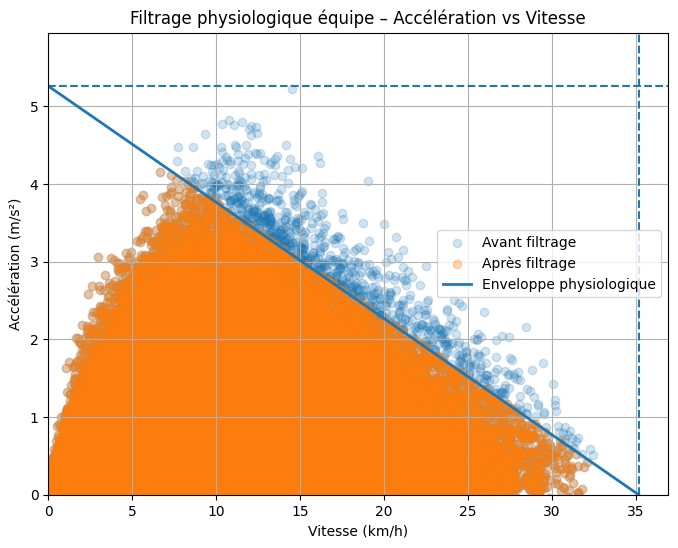

μV = 29.19 km/h | σV = 2.00 → V_lim = 35.17
μA = 4.72 m/s² | σA = 0.18 → A_lim = 5.26
Points supprimés : 828 / 581134


In [18]:
match = '2020-02-01'

#Norme Physiologique equipe vitesse et accélération
df_all = con.execute(f"""
SELECT
    player_pseudo,
    session_date,
    speed_kmh
FROM tracking_games
WHERE session_date = '{match}'
ORDER BY player_pseudo, session_date
""").df()

df_all['speed_ms'] = df_all['speed_kmh'] / 3.6

df_all['acceleration'] = (
    df_all
    .groupby('player_pseudo')['speed_ms']
    .diff()
    / dt
)
df_all = df_all.dropna(subset=['acceleration'])

df_all = df_all[
    (df_all['speed_kmh'] >= 0) &
    (df_all['speed_kmh'] <= 40) &        # plafond large
    (df_all['acceleration'].abs() <= 10) # m/s²
]

df_Vmax = (
    df_all
    .groupby('player_pseudo')['speed_kmh']
    .max()
    .reset_index(name='vmax')
)

mu_V = df_Vmax['vmax'].mean()
sigma_V = df_Vmax['vmax'].std()

V_lim = mu_V + 3 * sigma_V

df_Apos = df_all[df_all['acceleration'] > 4.5]

mu_A = df_Apos['acceleration'].mean()
sigma_A = df_Apos['acceleration'].std()

A_lim = mu_A + 3 * sigma_A

def is_physio_valid(speed, accel, V_lim, A_lim):
    return accel <= A_lim * (1 - speed / V_lim)

df_physio = df_all[
    (df_all['speed_kmh'] <= V_lim) &
    (df_all['acceleration'] <= A_lim) &
    (df_all.apply(
        lambda r: is_physio_valid(
            r['speed_kmh'],
            r['acceleration'],
            V_lim,
            A_lim
        ),
        axis=1
    ))
].copy()

v_line = np.linspace(0, V_lim, 200)
a_line = A_lim * (1 - v_line / V_lim)

plt.figure(figsize=(8, 6))

plt.scatter(
    df_all['speed_kmh'],
    df_all['acceleration'],
    alpha=0.2,
    label='Avant filtrage'
)

plt.scatter(
    df_physio['speed_kmh'],
    df_physio['acceleration'],
    alpha=0.3,
    label='Après filtrage'
)

plt.plot(v_line, a_line, linewidth=2, label='Enveloppe physiologique')

plt.axvline(V_lim, linestyle='--')
plt.axhline(A_lim, linestyle='--')

plt.xlabel('Vitesse (km/h)')
plt.ylabel('Accélération (m/s²)')
plt.xlim(0)
plt.ylim(0)
plt.title('Filtrage physiologique équipe – Accélération vs Vitesse')
plt.legend()
plt.grid(True)
plt.show()

print(f"μV = {mu_V:.2f} km/h | σV = {sigma_V:.2f} → V_lim = {V_lim:.2f}")
print(f"μA = {mu_A:.2f} m/s² | σA = {sigma_A:.2f} → A_lim = {A_lim:.2f}")
print(f"Points supprimés : {len(df_all) - len(df_physio)} / {len(df_all)}")



## Metrics

In [28]:
player = 6
match = '2020-02-01'
session_type = 'game'



#Metrics
# ===============================
# Récupérer les joueurs + positions pour ce match
# ===============================
df_match = con.execute(f"""
SELECT
    t.player_pseudo,
    t.sensor_id,
    s.position
FROM tracking_clean t
INNER JOIN summary s
    ON t.sensor_id = s.Sensor
    AND DATE(s.date) = t.session_date
WHERE t.session_date = DATE '{match}'
GROUP BY t.player_pseudo, t.sensor_id, s.position
""").df()



# ===============================
# Fonction de calcul des metrics
# ===============================
def compute_metrics(df_player):
    df_player = df_player.sort_values('time_utc')
    
    # Distance totale
    df_player['dist'] = np.sqrt(df_player['x_pos'].diff()**2 + df_player['y_pos'].diff()**2)
    max_distance = float(df_player['dist'].sum())
    
    # Accélération
    df_player['speed_ms'] = df_player['speed_kmh'] / 3.6
    df_player['acceleration'] = df_player['speed_ms'].diff() / dt
    
    metrics = {
        'max_speed': float(df_player['speed_kmh'].max()) if not df_player['speed_kmh'].empty else None,
        'max_distance': max_distance,
        'avg_acceleration': float(df_player['acceleration'].mean()),
        'max_acceleration': float(df_player['acceleration'].max()),
        'max_direction_changes': None,  # à remplir avec tes features si disponibles
        'max_sprints': None              # à remplir avec tes features si disponibles
    }
    
    return metrics


# ===============================
# Calculer metrics pour chaque joueur
# ===============================
metrics_rows = []
for player in df_match['player_pseudo'].unique():
    df_player = con.execute(f"""
    SELECT *
    FROM tracking_games
    WHERE session_date = '{match}'
    AND session_type = '{session_type}'
    AND player_pseudo = {player}
    """).df()
    
    metrics = compute_metrics(df_player)
    metrics_rows.append(metrics)

# Convertir en DataFrame
df_metrics = pd.DataFrame(metrics_rows)
df_final = pd.concat([df_match.reset_index(drop=True), df_metrics.reset_index(drop=True)], axis=1)


# ===============================
# Nom dynamique de la table
# ===============================
table_name = f"{session_type}_{match.replace('-', '_')}"

# ===============================
# Créer ou remplacer la table DuckDB
# ===============================
con.execute(f"CREATE OR REPLACE TABLE {table_name} AS SELECT * FROM df_final")
print(f"Table '{table_name}' créée/replacée avec succès !")


#Average Speed





#Max Speed
#Average Distance 
#Max Distance
#Average Acceleration
#Max Acceleration
#Average Number of direction changes
#Max Number of direction changes
#Average Number of sprints
#Max Number of sprints



Table 'game_2020_02_01' créée/replacée avec succès !


In [29]:
#Afficher la table game_2020_02_01
con.execute("SELECT * FROM game_2020_02_01").df()

,player_pseudo,sensor_id,position,max_speed,max_distance,avg_acceleration,max_acceleration,max_direction_changes,max_sprints
0,9,23,center back,28.63620,2929.858831,0.000718,3.744,<NA>,<NA>
1,10,4,center back,28.14480,10914.192864,0.000047,4.264,<NA>,<NA>
2,6,10,center forward,28.96200,3750.696557,0.000268,4.419,<NA>,<NA>
3,11,17,right back,27.70308,11025.607559,0.000148,5.224,<NA>,<NA>
4,14,13,center midfield,25.61364,11532.320429,0.000125,4.267,<NA>,<NA>
5,25,20,center forward,29.10708,494.109438,0.006091,3.145,<NA>,<NA>
6,35,77,center forward,32.47920,10971.088380,0.000173,4.501,<NA>,<NA>
7,34,5,center back,29.62296,10562.089489,0.000215,4.336,<NA>,<NA>
8,24,11,left forward,31.56300,11425.025530,0.000046,4.739,<NA>,<NA>
9,36,9,ran center,27.76032,7475.107215,0.000168,4.347,<NA>,<NA>


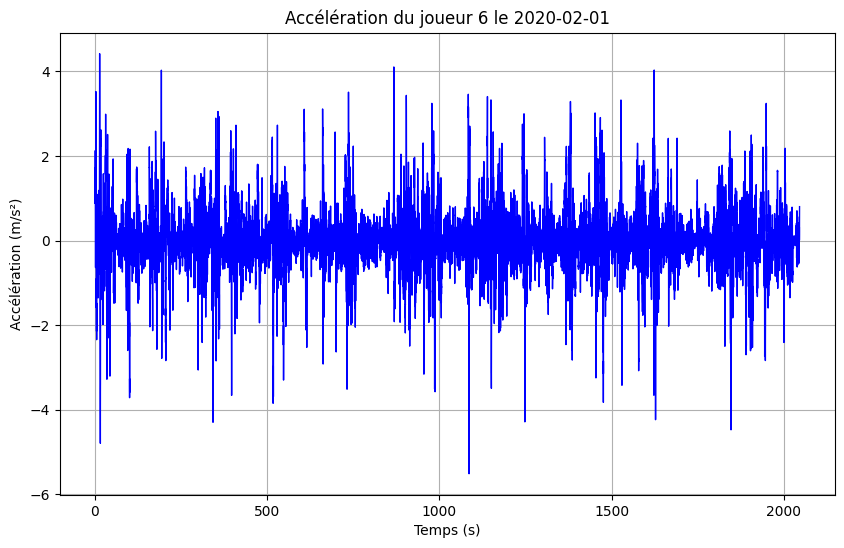

In [30]:

# ===============================
# Paramètres
# ===============================
player = 6
match = '2020-02-01'
fs = 10  # Hz
dt = 1 / fs

# ===============================
# Récupérer les données du joueur
# ===============================
df = con.execute(f"""
SELECT *
FROM tracking_games
WHERE session_date = '{match}'
AND player_pseudo = {player}
ORDER BY time_utc
""").df()

if df.empty:
    raise ValueError(f"Aucune donnée pour le joueur {player} le {match}")

# ===============================
# Calcul de la vitesse en m/s et de l'accélération
# ===============================
df['speed_ms'] = df['speed_kmh'] / 3.6
df['acceleration'] = df['speed_ms'].diff() / dt

# ===============================
# Création d'une colonne temps relatif en secondes
# ===============================
df['time_sec'] = (df['time_utc'] - df['time_utc'].iloc[0]).dt.total_seconds()

# ===============================
# Tracé
# ===============================
plt.figure(figsize=(10, 6))
plt.plot(df['time_sec'], df['acceleration'], color='blue', linewidth=1)
plt.xlabel('Temps (s)')
plt.ylabel('Accélération (m/s²)')
plt.title(f'Accélération du joueur {player} le {match}')
plt.grid(True)
plt.show()
